<h1> Activation Functions for Non-Linear Function Approximation</h1> <br>

<img src="https://upload.wikimedia.org/wikipedia/commons/4/42/ReLU_and_GELU.svg" width="500" align="center">


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

In [2]:
# Create a data distribution
def create_data(data_points):
    data_class1 = torch.rand(data_points, 2) * 1.45
    data_class2 = torch.rand(data_points, 2) * 3
    
    mask = ~((data_class2[:, 0] < 1.55) * (data_class2[:, 1] < 1.55))
    data_class2 = data_class2[mask]

    # Lables
    data_label1 = torch.zeros(data_class1.shape[0], 1)
    data_label2 = torch.ones(data_class2.shape[0], 1)

    # Combine data
    x_data = torch.cat((data_class1, data_class2), 0)
    y_data = torch.cat((data_label1, data_label2), 0)
    
    return x_data, y_data

In [3]:
# Combine data
x_train, y_train = create_data(1000)
x_test, y_test = create_data(500)

<h3> Let's plot our data </h3>

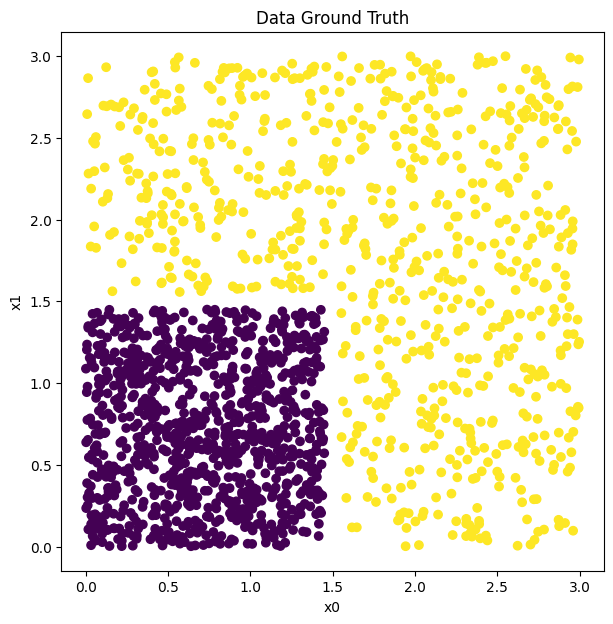

In [4]:
# Lets see what the data looks like
plt.figure(figsize=(7, 7))
plt.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), c=y_train.flatten().numpy())
_ = plt.xlabel("x0")
_ = plt.ylabel("x1")
_ = plt.title("Data Ground Truth")

<h2>Create a Linear Logistic Regression Model</h2>

In [5]:
logistic_linear = nn.Linear(2, 1) 
loss_function = nn.BCEWithLogitsLoss()

# Create our optimizer - lr = 0.1
logistic_optimizer = torch.optim.Adam(logistic_linear.parameters(), lr=0.1)
# Number of times we iterate over the dataset
max_epoch = 100

logistic_loss_log = [] # keep track of the loss values
logistic_acc = [] # keep track of the accuracy 
for epoch in range(max_epoch):
    with torch.no_grad():
        y_test_hat = logistic_linear(x_test)
        
        # The descision boundary is at 0.5 (between 0 and 1) AFTER the sigmoid
        # The input to the Sigmoid function that gives 0.5 is 0!
        # Therefore the descision boundary for the RAW output is at 0!!
        class_pred = (y_test_hat > 0).float()
        logistic_acc.append(float(sum(class_pred == y_test))/ float(y_test.shape[0]))
        
    # Perform a training step
    y_train_hat = logistic_linear(x_train)
    loss = loss_function(y_train_hat, y_train)
    
    logistic_optimizer.zero_grad()
    loss.backward()
    logistic_optimizer.step()

    logistic_loss_log.append(loss.item())
    
print("Accuracy of linear model(GD): %.2f%% " %(logistic_acc[-1]*100))

Accuracy of linear model(GD): 92.52% 


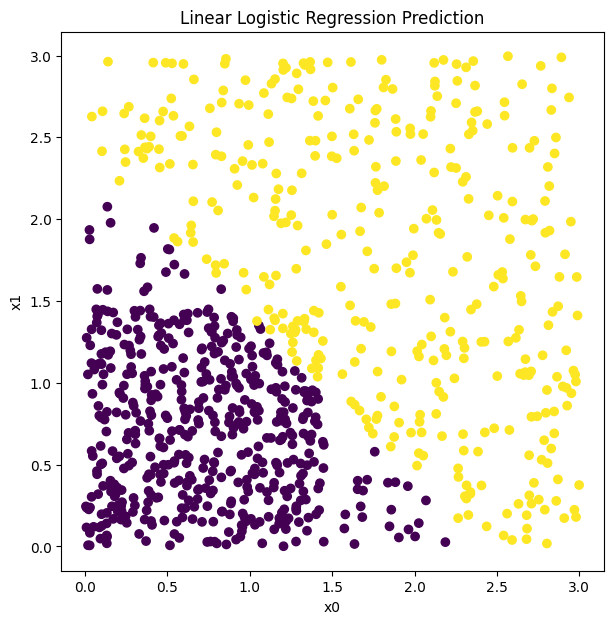

In [6]:
# Lets see what the data looks like
plt.figure(figsize=(7, 7))
plt.scatter(x_test[:, 0].numpy(), x_test[:, 1].numpy(), c=class_pred.flatten().numpy())
_ = plt.xlabel("x0")
_ = plt.ylabel("x1")
_ = plt.title("Linear Logistic Regression Prediction")

<h2> Non-Linear function approximators! </h2> <br>

Up until now we have only created a single linear layer with an input layer and an output layer. In this section we will start to create multi-layered networks with many "hidden" layers separated by "activation functions" that give our networks "non-linearities". If we didn't have these activation functions and simply stacked layers together, our network would be no better than a single linear layer! Why? Because multiple sequential "linear transformations" can be modeled with just a single linear transformation. This is easiest to understand with matrix multiplications (which is exactly what happens inside a linear layer).<br>

$M_o = M_i*M_1*M_2*M_3*M_4*M_5$<br>
Is the same as<br>
$M_o = M_i*M_T$<br>
Where<br>
$M_T = M_1*M_2*M_3*M_4*M_5$<br>

Aka multiplication with several matrices can be simplified to multiplication with a single matrix.<br>

So what are these nonlinear activation functions that turn our simple linear models into a power "nonlinear function approximator"? Some common examples are:<br>
1. relu
2. sigmoid
3. tanh

Simply put they are "nonlinear" functions, the simplest of which is the "rectified linear unit" (relu) which is "piecewise non-linear".

NOTE: The term "layer" most commonly refers to the inputs or outputs of the weight matrix or activations functions and not the linear layer or activation layer themselves. Output layers in between two "linear layers" are called "hidden layers". You can imagine them "inside" the neural network with us only being able to see the input and output layers. To confuse things even further the outputs of activation functions are also commonly called "activations"

Why do we want a linear function approximator? Because many processes, tasks, systems in the real world are non-linear. "Linear" in basic terms refers to any process that takes inputs, scales them and sums them together to get an output. 

<h3>Hand Build a Non-Linear Neural Network!</h3>

In [7]:
# Using the equation 0 = w0*x0 + w1*x1 + w2
# Consider each input dimention intependantly 
# Therefore we have 2 equations 0 = w0*x0 + w1
# -w1/w0 = 1.5
# Pick any w1 and calculate w0

w0 = 1
w1 = -(1.5 * w0)
w_0 = torch.FloatTensor([[w0, 0], [0, w0]])
b_0 = torch.FloatTensor([[w1, w1]])
print("Weights", w_0.numpy())
print("bias", b_0.numpy())

h1 = F.linear(x_train, w_0, bias=b_0)
h2 = torch.sigmoid(h1)

Weights [[1. 0.]
 [0. 1.]]
bias [[-1.5 -1.5]]


Text(0.5, 1.0, 'Sigmoid output')

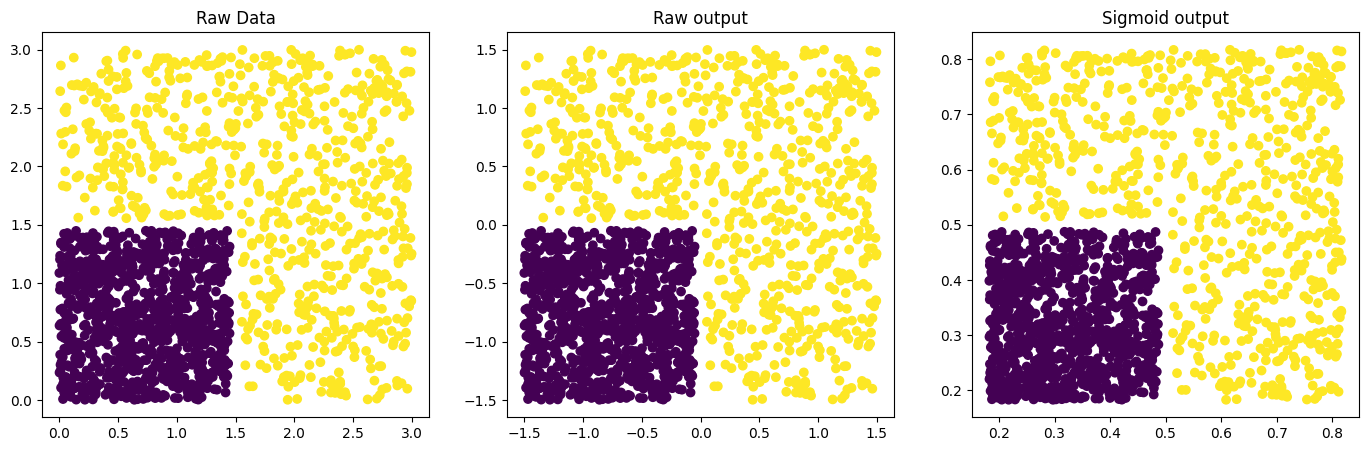

In [8]:
# Plot out the Raw data vs Raw output and Sigmoid output
# What happens as you increase w0???
# Increase w0 untill the data becomes linearly seperable!

plt.figure(figsize=(17, 5))
plt.subplot(131)
plt.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), c=y_train.flatten().numpy())
plt.title("Raw Data")

plt.subplot(132)
plt.scatter(h1[:, 0].numpy(), h1[:, 1].numpy(), c=y_train.flatten().numpy())
plt.title("Raw output")

plt.subplot(133)
plt.scatter(h2[:, 0].numpy(), h2[:, 1].numpy(), c=y_train.flatten().numpy())
plt.title("Sigmoid output")


<h3>Second Layer</h3>
Now that we've mapped the input data into a space that is <b> linearly separable </b> we can create ANOTHER layer that takes in this second (hidden) layer

In [9]:
# Create a line between the points (0, 0.6) and (0.6, 0)
point0 = torch.tensor([0.6, 0])
point1 = torch.tensor([0, 0.6])

w0 = 1
w1 = 1
w2 = -0.6
w_1 = torch.FloatTensor([[w0, w1]])
b_1 = torch.FloatTensor([w2])
print("Weights", w_1.numpy())
print("bias", b_1.numpy())

h3 = F.linear(h2, w_1, bias=b_1)
class_pred = (h3 > 0).float()

# Calculate the accuracy!
acc = float(sum(class_pred == y_train))/ float(y_train.shape[0])
print("Non-linear accuracy %.2f%%" % (acc * 100))

Weights [[1. 1.]]
bias [-0.6]
Non-linear accuracy 64.16%


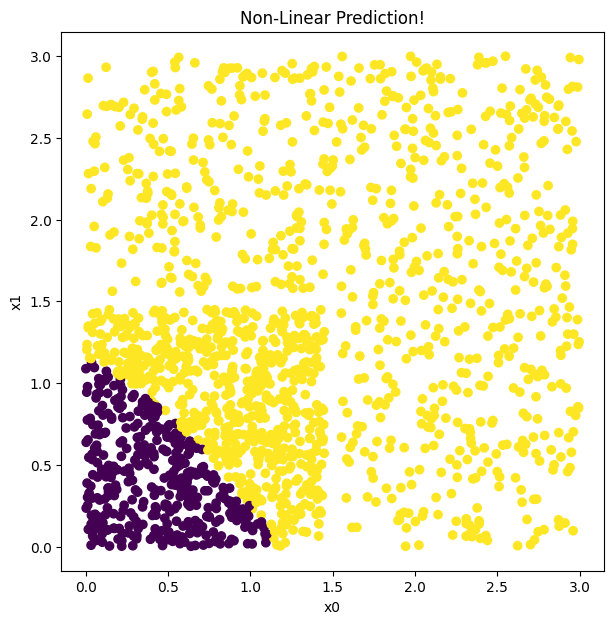

In [10]:
plt.figure(figsize=(7, 7))

plt.scatter(x_train[:, 0].numpy(), x_train[:, 1].numpy(), c=class_pred.flatten().numpy())
_ = plt.xlabel("x0")
_ = plt.ylabel("x1")
_ = plt.title("Non-Linear Prediction!")

<h2>Train a Non-Linear Logistic Regression Model With Pytorch</h2>
Now that we have seen the power of a non-linear Neural Network let's see how we can create and train one automatically with Pytorch!

In [11]:
# Recreate the non-linear architecture that we used with Pytorch linear layers!
class NonLinearModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(NonLinearModel, self).__init__() 
        self.linear1 = nn.Linear(input_size, hidden_size)         
        self.linear2 = nn.Linear(hidden_size, output_size) 

    def forward(self, x):
        self.h1 = self.linear1(x)
        self.h2 = torch.sigmoid(self.h1)
        self.h3 = self.linear2(self.h2)
        
        return self.h3

In [12]:
# The parameters of the Neural Network are randomly initialised so we must use gradient decent to find the 
# optimal parameters!

logistic_nonlinear = NonLinearModel(input_size=2, output_size=1, hidden_size=2) 
loss_function = nn.BCEWithLogitsLoss()

# Create our optimizer - lr = 0.1
logistic_optimizer = torch.optim.Adam(logistic_nonlinear.parameters(), lr=1e-2)

logistic_loss_log = [] # keep track of the loss values
logistic_acc = [] # keep track of the accuracy 

In [13]:
# Number of times we iterate over the dataset
max_epoch = 5000

for epoch in trange(max_epoch, desc="Training Epochs"):
    with torch.no_grad():
        y_test_hat = logistic_nonlinear(x_test)
        
        # The descision boundary is at 0.5 (between 0 and 1) AFTER the sigmoid
        # The input to the Sigmoid function that gives 0.5 is 0!
        # Therefore the descision boundary for the RAW output is at 0!!
        class_pred = (y_test_hat > 0).float()
        logistic_acc.append(float(sum(class_pred == y_test))/ float(y_test.shape[0]))
        
    # Perform a training step
    y_train_hat = logistic_nonlinear(x_train)
    loss = loss_function(y_train_hat, y_train)
    
    logistic_optimizer.zero_grad()
    loss.backward()
    logistic_optimizer.step()

    logistic_loss_log.append(loss.item())
    
print("Accuracy of Non-linear model(GD): %.2f%% " %(logistic_acc[-1]*100))

Training Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy of Non-linear model(GD): 92.29% 


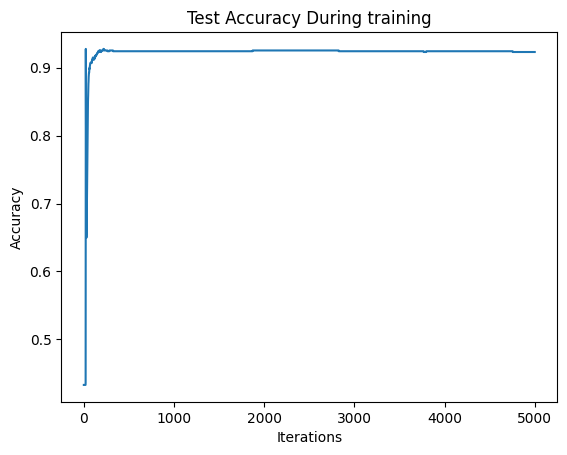

In [14]:
plt.plot(logistic_acc)
_ = plt.xlabel("Iterations")
_ = plt.ylabel("Accuracy")
_ = plt.title("Test Accuracy During training")

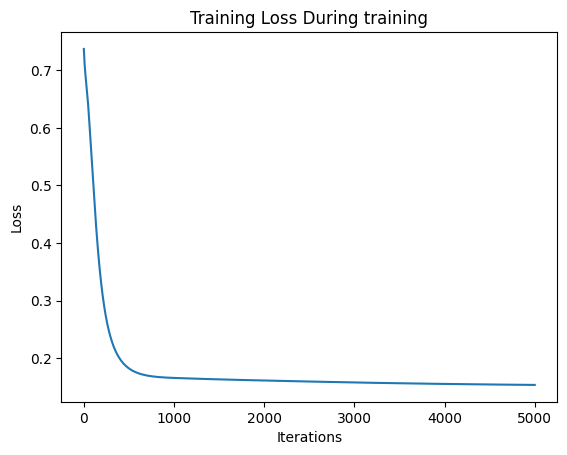

In [15]:
plt.plot(logistic_loss_log)
_ = plt.xlabel("Iterations")
_ = plt.ylabel("Loss")
_ = plt.title("Training Loss During training")

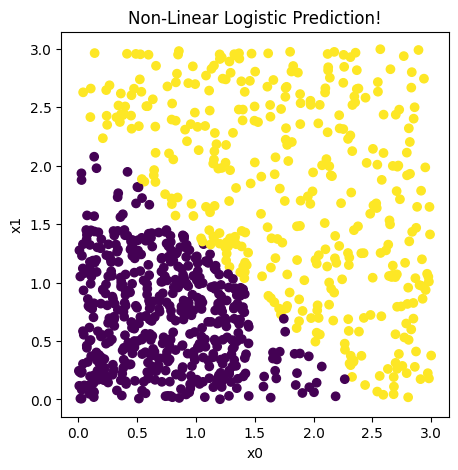

In [16]:
with torch.no_grad():
    y_test_hat = logistic_nonlinear(x_test)
    class_pred = (y_test_hat > 0).float()
    
plt.figure(figsize=(5, 5))    
plt.scatter(x_test[:, 0].numpy(), x_test[:, 1].numpy(), c=class_pred.flatten().numpy())
_ = plt.xlabel("x0")
_ = plt.ylabel("x1")
_ = plt.title("Non-Linear Logistic Prediction!")

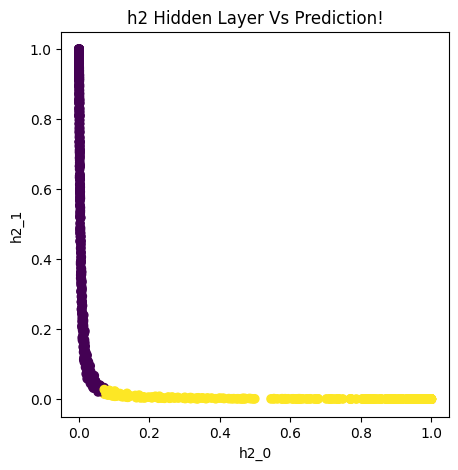

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(logistic_nonlinear.h2[:, 0].numpy(), 
            logistic_nonlinear.h2[:, 1].numpy(), 
            c=class_pred.flatten().numpy())

_ = plt.xlabel("h2_0")
_ = plt.ylabel("h2_1")
_ = plt.title("h2 Hidden Layer Vs Prediction!")

In [18]:
logistic_nonlinear.linear2.bias

Parameter containing:
tensor([-0.4424], requires_grad=True)